*Coding session: Introduction to Word2Vec*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//unstructured-data/africa_es/blob/main/notebooks/1_word_embeddings.ipynb)

This tutorial illustrates several applications of word embeddings by estimating a Word2Vec model on the inflation reports from the Bank of England. We will use an off-the-shelf Python library (```Gensim```) to estimate the model. [Gensim](https://radimrehurek.com/gensim/index.html) is a very powerful library that contains efficient (written in ```C```) implementations of several NLP models.

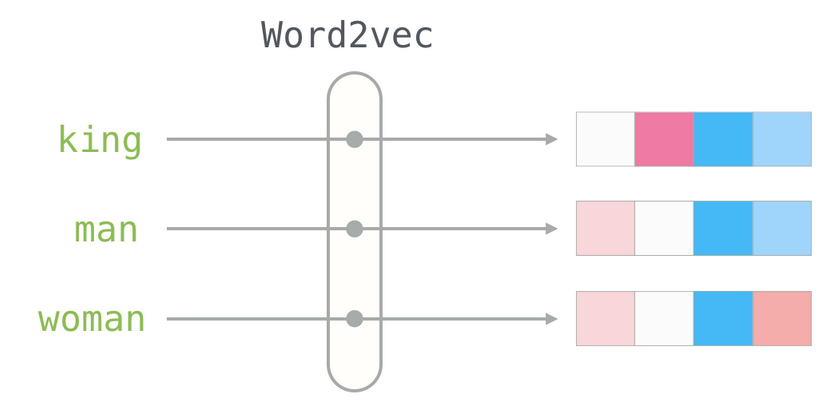

*Source: Alammar (2019)*

Some additional resources on Word2Vec:
- **Book chapter**. Jurafsky & Martin (2021). *Vector Semantics and
Embeddings*. [Available online.](https://web.stanford.edu/~jurafsky/slp3/6.pdf)
- **Original word2vec paper**. Mikolov et al. (2013). *Efficient Estimation of Word Representations in
Vector Space*. [Available online.](https://arxiv.org/pdf/1301.3781.pdf)
- **Paper.** Rong (2016). *word2vec Parameter Learning Explained*. [Available online.](https://arxiv.org/pdf/1411.2738.pdf)
- **Blog post.** Alammar (2019). *The Illustrated Word2vec*.[Available online.](https://jalammar.github.io/illustrated-word2vec/)
- **Applied paper.**  Garg et al. (2018) . *Word embeddings quantify 100 years of gender and ethnic stereotypes*. [Available online](https://www.pnas.org/doi/10.1073/pnas.1720347115).
- [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)

# 0. Setup

In [ ]:
%%capture

# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions
!pip3 install spacy                      # functions for lemmatizing
!pip3 install gensim==4.0.0              # word2vec estimation
!pip3 install adjustText                 # generate plots with lots of text labels
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library

# install Spacy's language model
# for more languages and models check: https://spacy.io/models
!python3 -m spacy download en_core_web_sm

In [ ]:
# clone the GitHub repository with the preprocessing scripts
!git clone https://github.com/unstructured-data-research/text-preprocessing

In [ ]:
#### import libraries

# basic libraries
import sys
import pandas as pd
import numpy as np
import string
from collections import Counter
from IPython.core.display import HTML

# libraries for plots and figures
import matplotlib.pyplot as plt
from adjustText import adjust_text

# word2vec implementation
from gensim.models import Word2Vec
import gensim.downloader as api

# scikit-learn relevant classes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# text processing
import spacy
nlp_standard = spacy.load('en_core_web_sm')

# import our own modules
sys.path.append('./text-preprocessing/src')
import preprocessing_class as pc
import dictionary_methods as dictionary_methods

In [ ]:
info = api.info()
info["models"].keys()

In [ ]:
info["models"]["word2vec-google-news-300"]

In [ ]:
 # download the model and return as object ready for use
pt_model = api.load("glove-twitter-25")

In [ ]:
pt_model.most_similar("liquidity", topn=5)

In [ ]:
pt_model.most_similar("bond", topn=5)

# 1. Load data and preprocess text

We will start by loading some real text data over which we will estimate our word embeddings. Concretely, we will work with the [Inflation Reports produced by the Bank of England](https://www.bankofengland.co.uk/inflation-report/inflation-reports). The data starts on 1998 and ends in 2015. Reports are produced four times a year in the months of February, May, August and November. [Here](https://www.bankofengland.co.uk/-/media/boe/files/inflation-report/2019/may/inflation-report-may-2019.pdf?la=en&hash=D4985F6D513BF04EB81A28C53F6DB0CFB8CC09FB) you can see how these reports look like.

In [ ]:
# load the Inflation Reports (IR) data
file_id = "1XZRwMomnHc-bPY9CgVshzNtZN5uY9Oaa"
data = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download",
                   sep="\t")

data = data[['ir_date', 'paragraph']]
data.columns = ['yearmonth', 'paragraph']
print(data.shape)
data.head(10)

In [ ]:
# explore one of the paragraphs
data.loc[0, "paragraph"]

In [ ]:
# check how often these reports are produced
grouped = data.groupby("yearmonth", as_index=False).size()
print(grouped.head(5))
print("\n\n")
print(grouped.tail(5))

Before estimating word embeddings, it is important to pre-process the data. To do this, we will use a custom-built preprocessing Python library. This library implements a wide-range of functions for cleaning text. If you want to inspect the source code, visit the public repository [here](https://github.com/unstructured-data-research/text-preprocessing).

For a more detailed discussion on preprocessing check the notebook for the first TA session.

We will start by creating a function that applies all the preprocessing steps in the correct order. We should provide the documents that we want to preprocess along side some key parameters. The function will return an object ```prep``` that we will use.

In [ ]:
def apply_preprocessing(data, item_type, stopwords_type, replacing_dict, pattern, punctuation):
    """ Function to apply the steps from the preprocessing class in the correct
        order to generate a term frequency matrix
    """

    # initialize the class with the text data and some parameters
    prep = pc.RawDocs(data)

    # replace some specific phrases of interest
    prep.phrase_replace(replace_dict=replacing_dict,
                        sort_dict=True,
                        case_sensitive_replacing=False)

    # lower-case text and expand contractions
    prep.basic_cleaning(lower_case=True,
                        contraction_split=True)

    # split the documents into tokens
    prep.tokenize_text(tokenization_pattern=pattern)

    # clean tokens (remove non-ascii characters, remove short tokens, remove punctuation and numbers)
    prep.token_clean(length=2,
                    punctuation=punctuation,
                    numbers=True)

    # remove stopwords
    if item_type == "tokens":
        prep.stopword_remove(items='tokens', stopwords=stopwords_type)
    elif item_type == "lemmas":
        prep.lemmatize()
        prep.stopword_remove("lemmas", stopwords=stopwords_type)
    elif item_type == "stems":
        prep.stem()
        prep.stopword_remove("stems", stopwords=stopwords_type)

    return prep

In [ ]:
# define dictionary for preprocessing class with terms we want to preserve
replacing_dict = {'monetary policy':'monetary-policy',
                  'interest rate':'interest-rate',
                  'interest rates':'interest-rate',
                  'yield curve':'yield-curve',
                  'repo rate':'repo-rate',
                  'bond yields':'bond-yields',
                  'real estate':'real-estate',
                  'economic growth':'economic-growth'}

In [ ]:
# define tokenization pattern and punctuation symbols
pattern = r'''
          (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
          \w+(?:-\w+)*        # word characters with internal hyphens
          | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
          '''
punctuation = string.punctuation.replace("-", "")

In [ ]:
# use preprocessing class
prep = apply_preprocessing(data.paragraph,
                            "tokens",
                            "long",
                            replacing_dict,
                            pattern,
                            punctuation)

In [ ]:
# get the tokens from the "prep" object
tokens = prep.tokens

In [ ]:
# inspect a particular tokenized document and compare it to its original form
i = 10
print(data.paragraph[i])
print("\n ------------------------------- \n")
print(tokens[i])

# 2. Model estimation

Now that we have our text preprocessed we can use the [Gensim](https://radimrehurek.com/gensim/) library to efficiently estimate word embeddings using word2vec.

In [ ]:
# train Gensim's Word2Vec model (takes less than a minute!)
gensim_model = Word2Vec(sentences=tokens,           # corpus (i.e. list of tokenized documents)
                        vector_size=100,            # embedding dimension
                        window=5,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=10,                # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=5,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=1,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                       )

In [ ]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors

In [ ]:
vectors_array= word_vectors.vectors
vectors_array.shape     # vocab_size x embeddings dimension

In [ ]:
# get the index of any token in the vocabulary
word_vectors.get_index("economy")

# 3. Visualization

There a lot of different ways in which we can use these estimated word embeddings. We will start by showing a simple way to visualize them in 2-dimensions.

In [ ]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):

    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0, size=16))

    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

In [ ]:
# define the tokens to use in the plot
tokens_of_interest = ['economy', 'gdp', 'production', 'output',
                      'investment', 'confidence', 'sentiment',
                      'uncertainty', 'inflation', 'cpi',
                      'loan', 'mortgage', 'credit', 'debt', 'savings',
                      'borrowing', 'housing', 'labour', 'workforce',
                      'unemployment', 'employment', 'jobs', 'wages',
                      'trade', 'exports', 'imports']

# expand the list of tokens with all the tokens from the replacement dictionary
tokens_of_interest = set(tokens_of_interest + list(replacing_dict.values()) )

# plot
pca_scatterplot(word_vectors, list(tokens_of_interest))

# 4. Nearest neighbors analysis

We can further explore how words cluster in the embedded space by analyzing the nearest neighbours of some selected words.

In [ ]:
# find the K nearest neighbours of relevant words
K = 5
words = ["uncertainty", "risk", "stable",
         "contraction", "expansion",
         "monetary-policy", "interest-rate", "inflation"]

for word in words:
    print(f"Nearest neighbors of: {word}")
    print(word_vectors.most_similar(word, topn=K))
    print("\n")

# 5. Analogy tasks

A very interesting, and surprising, use of word embeddings is to find word analogies. The famous example used by [Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf) searches for a word $X$ in the embedded space that is similar to "woman" in the same sense that "king" is similar to "man". This task can be expressed in terms of a simple vector arithmetic problem as follows:

$$
\vec{King}^{\,} - \vec{Man}^{\,} = \vec{X}^{\,} - \vec{Woman}^{\,} \\
\vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} = \vec{X}^{\,}
$$

Mikolov et al. (2013) find that when performing this operation on their trained embeddings, they are able to recover the word "queen".

$$ \vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} \approx \vec{Queen}^{\,} $$

Using ```Gensim``` this operation can be very easily perfomed by simply using the ```.most_similar()``` function as follows:

<center>

```python
word_vectors.most_similar(positive=['king', 'woman'], negative=['man'])
```

</center>

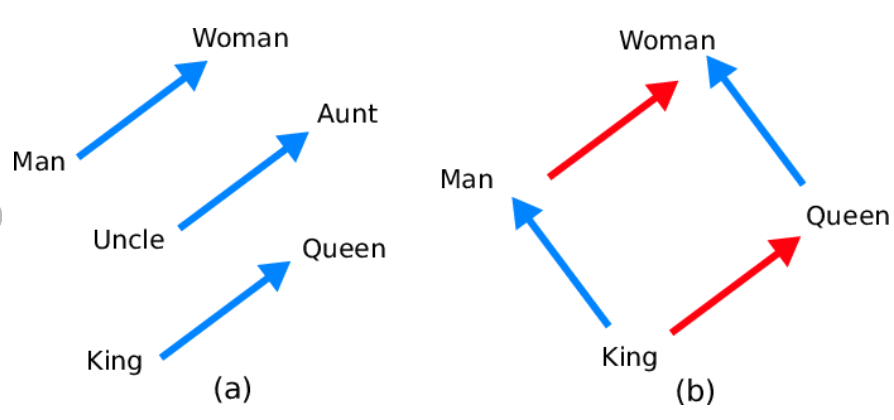

We will play with this idea and try to extend it to our own domain. Some of the analogies that we will try to solve are:

$$
\vec{Contraction}^{\,} - \vec{Expansion}^{\,} + \vec{Downward}^{\,} = \vec{X}^{\,} \\
\vec{Inflation}^{\,} - \vec{CPI}^{\,} + \vec{GDP}^{\,} = \vec{X}^{\,} \\
$$

In words:

- "expansion" is to "contraction" as "downward" is to ...
- "inflation" is to "CPI" as "gdp" is to ...

In [ ]:
# create the analogy tasks for our data
positive_words = [['contraction', 'downward'],
                  ['inflation', 'gdp'],
                  ['company', 'wages'],
                  ['expansion', 'tighten']]

negative_words = [['expansion'],
                  ['cpi'],
                  ['profits'],
                  ['contraction']]

for pw, nw in zip(positive_words, negative_words):
    #print(f"Analogy task for positive words: {pw} and negative words {nw}")
    print(f"'{nw[0]}' is to '{pw[0]}' as '{pw[1]}' is to:")
    print(word_vectors.most_similar(positive=pw, negative=nw))
    print("\n")

# 6. Building dictionaries

One last use of word embeddings is to expand existing dictionaries by finding the nearest neighbours to a set of "center" terms. To illustrate this, we will come show how to generate dictionaries of positive and negative terms to analyze text data from the Bank of England Monetary Police Comittee minutes.

In [ ]:
# create a positive dictionary by finding the nearest neighbors to a combination of relevant words
N = 20
pos_center_terms = ['expansion', 'stable']
pos_nn = [w for w, _ in word_vectors.most_similar(positive=pos_center_terms, topn=N)]
pos_word2vec = pos_center_terms + pos_nn
print(pos_word2vec)

In [ ]:
# create a negative dictionary by finding the nearest neighbors to a combination of relevant words
N = 20
neg_center_terms = ['contraction', 'uncertainty']
neg_nn = [w for w, _ in word_vectors.most_similar(positive=neg_center_terms, topn=N)]
neg_word2vec = neg_center_terms + neg_nn
print(neg_word2vec)

In [ ]:
# download file
import gdown
gdown.download("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR",
               "./mpc_minutes.txt", quiet=False)

In [ ]:
# load data for dictionary method example (might take a couple of minutes if we use lemmas or stems)
data_dict, prep_dict = dictionary_methods.dict_example("mpc_minutes.txt", "tokens", replacing_dict) # dataframe, preprocessing object

In [ ]:
# generate the count of positive and negative tokens in the corpus with our new dictionaries
pos_counts_word2vec, neg_counts_word2vec = dictionary_methods.pos_neg_counts(prep_dict,
                                                                             items="tokens",
                                                                             pos_terms=pos_word2vec,
                                                                             neg_terms=neg_word2vec,
                                                                             nlp_standard=nlp_standard)

In [ ]:
# add counts to the data
data_dict['pos_counts_word2vec'] = pos_counts_word2vec
data_dict['neg_counts_word2vec'] = neg_counts_word2vec
data_dict

In [ ]:
# Apel and Blix-Grimaldi (2012) dictionaries
pos_words_AB = ["high", "higher", "highest",
                "strong", "stronger", "strongest",
                "increase", "increases", "increased","increasing",
                "fast", "faster", "fastest"]

neg_words_AB = ["low", "lower", "lowest",
                "weak", "weaker", "weakest",
                "decrease", "decreases", "decreased", "decreasing",
                "slow", "slower", "slowest"]

# generate the count of positive and negative lemmas in the corpus with Apel and Blix-Grimaldi (2012)
pos_counts_AB, neg_counts_AB = dictionary_methods.pos_neg_counts(prep_dict,
                                              items="tokens",
                                              pos_terms=pos_words_AB,
                                              neg_terms=neg_words_AB,
                                              nlp_standard=nlp_standard)

# add counts to the data
data_dict['pos_counts_AB'] = pos_counts_AB
data_dict['neg_counts_AB'] = neg_counts_AB
data_dict.head()

In [ ]:
# aggregate to year-month level
data_agg = data_dict.groupby(['date']).agg({'pos_counts_word2vec': 'sum', 'neg_counts_word2vec': 'sum',
                                            'pos_counts_AB': 'sum', 'neg_counts_AB': 'sum',
                                            'year': 'mean', 'quarter':'mean'})
data_agg.head()

In [ ]:
# aggregate to year-quarter level removing incomplete quarters
data_agg['months_x_quarter'] = 1
data_agg = data_agg.groupby(['year', 'quarter']).sum()[['pos_counts_word2vec', 'neg_counts_word2vec',
                                                        'pos_counts_AB', 'neg_counts_AB',
                                                        'months_x_quarter']]

data_agg = data_agg[data_agg['months_x_quarter']==3]
del data_agg['months_x_quarter']

data_agg.head()

In [ ]:
# compute sentiment at year-quarter level
data_agg['sentiment_word2vec'] = (data_agg.pos_counts_word2vec - data_agg.neg_counts_word2vec)/(data_agg.pos_counts_word2vec + data_agg.neg_counts_word2vec)
data_agg['sentiment_AB'] = (data_agg.pos_counts_AB - data_agg.neg_counts_AB)/(data_agg.pos_counts_AB + data_agg.neg_counts_AB)
data_agg.head()

Next we add quarterly GDP data collected from the ONS website.

In [ ]:
# load GDP data
file_id = "1fkpIBWubswWA2Y3YtJgIEhqDikxxftZ8"
df_gdp = pd.read_csv(f"https://drive.google.com/uc?export=download&id={file_id}&authuser=0&export=download")
df_gdp.head()

In [ ]:
# merge to sentiment data
df = data_agg.merge(df_gdp, how='left', on=['year', 'quarter']).copy()

# create year-quarter variable
df["year_quarter"] = df.apply(lambda x: f"{int(x['quarter'])}Q{int(x['year'])}", axis=1)
df["year_quarter"] = df["year_quarter"].apply(lambda x: pd.Period(value=x, freq="Q").to_timestamp())
df.head()

In [ ]:
print(df[['gdp_growth', 'sentiment_AB', 'sentiment_word2vec']].corr())

In [ ]:
# standardize and plot all series
scaler = StandardScaler()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_AB.values.reshape(-1, 1)),
                                                 label="Apel and Blix-Grimaldi (2012)", linestyle='dashed', c='black')

ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_word2vec.values.reshape(-1, 1)),
                                                 label="Word2Vec dictionaries", linestyle='dashed', c='orange')

ax.plot(df["year_quarter"], scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)), label="GDP Growth")

plt.legend()
plt.show()